In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import csv 
import networkx as nx
from random import sample
import time
import math
import random
import scipy
import pandas as pd

In [2]:
# Define necessary functions

def arccosh_og(x):  ##note that x*x-1 might be less than zero :( And then log(t) could be negative (negative distance?!?!?!?!)
    t = x + math.sqrt(x * x - 1)
    return math.log(t)

def arccosh(x):
    t = x + math.sqrt(max(x * x, 1) - 1)
    return max(math.log(t), 0.5)
    
def query(coordinates, source, destination, curvature):
    
    if source == destination:
        return 0
    
    sourceCoords = coordinates[source]
    destinationCoords = coordinates[destination]

    i = 0
    ts = 1.0
    td = 1.0
    tt = 1.0

    for i in range(len(sourceCoords)):
        ts += math.pow(sourceCoords[i], 2)
        td += math.pow(destinationCoords[i], 2)
        tt += (sourceCoords[i] * destinationCoords[i])
    #print(ts, td, tt)
    t = math.sqrt(ts * td) - tt
    #print('t:', t)
    return arccosh(t) * math.fabs(curvature)

In [3]:
# READ REAL NETWORK - GCC

dataset = 'HU_edges.csv' #'large_twitch_edges.csv'

data = pd.read_csv(dataset, header = 0, sep = ',') 
data = data[[data.columns[0], data.columns[1]]]
data.head()

graph = nx.from_pandas_edgelist(data, data.columns[0], data.columns[1])
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
giant = graph.subgraph(Gcc[0])

In [5]:
# SPECIFY THESE INPUTS

output_file_name = 'deezer/out'
partitions = 1
curvature = -1
number_of_nodes = 47538

#######################


landFile = output_file_name + '.land'
coordFiles = [output_file_name + str(i) + '.coord' for i in range(partitions)]

coordinates = dict()
with open(landFile) as infile:
    for line in infile:
        linesplit = line.split()
        id = int(linesplit[0])
        coords = [float(c) for c in linesplit[1:]]
        coordinates[id] = coords

for coordFile in coordFiles:
    with open(coordFile) as infile:
        for line in infile:
            linesplit = line.split()
            id = int(linesplit[0])
            coords = [float(c) for c in linesplit[1:]]
            coordinates[id] = coords

#while True:
#    query_input = input("Enter ID of 2 nodes: ")
        
#    if query_input == 'exit' or query_input == 'q' or query_input == 'quit':
       # break

#    querysplit = query_input.split()
#    source = int(querysplit[0])
#    destination = int(querysplit[1])

#    estimate = query(coordinates, source, destination, curvature)
#    print('Rigel estimates the distance between %d and %d to be %f.\n' % (source, destination, estimate))


In [7]:
# Relative errors - approximation: select 'select_count = 1000'  nodes from where distances (to all nodes) are calculated
### This is necessary due to slow EXACT path calculation

np.random.seed(0)

select_count = 4000
selected_nodes = random.sample(range(number_of_nodes), select_count)

relative_errors = dict()
exact_distances = dict()
estimated_distances= dict()

avg_path_length_exact = 0
avg_path_length_estimated = 0
radius_estimated = number_of_nodes
diameter_estimated = 0
radius_exact = number_of_nodes
diameter_exact = 0
eccentricites_estimated = []
eccentricites_exact  =[]


node_names = list(giant.nodes())

iters = 0

for source in selected_nodes:
    iters += 1
    if iters % int(select_count/10) == 0:
        print('Processed ', 10 * iters / int(select_count/10), '% of total calculations...')
    
    eccentricity_curr_est = 0
    eccentricity_curr_ex = 0
    exact_distances[source] = []
    estimated_distances[source] = []
    relative_errors[source] = []
    for target in selected_nodes:
        #print('points:', source, target)
        if source != target:
            estimate = query(coordinates, source, target, curvature)
            exact = nx.shortest_path_length(giant, node_names[source], node_names[target])
            avg_path_length_estimated += estimate
            avg_path_length_exact += exact
            eccentricity_curr_est = max(eccentricity_curr_est, estimate)
            diameter_estimated = max(diameter_estimated, estimate)
            eccentricity_curr_ex = max(eccentricity_curr_ex,exact)
            diameter_exact = max(diameter_exact,exact)
            relative_errors[source].append(abs(estimate-exact)/exact)
            exact_distances[source].append(exact)
            estimated_distances[source].append(estimate)
        else:
            relative_errors[source].append(0)
            exact_distances[source].append(0)
            estimated_distances[source].append(0)
    radius_estimated = min(eccentricity_curr_est, radius_estimated)
    radius_exact = min(eccentricity_curr_ex, radius_exact)
    eccentricites_estimated.append(eccentricity_curr_est)
    eccentricites_exact.append(eccentricity_curr_ex)
        
avg_path_length_estimated = avg_path_length_estimated / (select_count * (select_count - 1) )
avg_path_length_exact = avg_path_length_exact / (select_count * (select_count - 1) )

Processed  10.0 % of total calculations...
Processed  20.0 % of total calculations...
Processed  30.0 % of total calculations...
Processed  40.0 % of total calculations...
Processed  50.0 % of total calculations...
Processed  60.0 % of total calculations...
Processed  70.0 % of total calculations...
Processed  80.0 % of total calculations...
Processed  90.0 % of total calculations...
Processed  100.0 % of total calculations...


In [8]:
print(avg_path_length_estimated)
print(avg_path_length_exact)
print(radius_estimated)
print(radius_exact)
print(diameter_estimated)
print(diameter_exact)

5.129061703389605
5.352727306826707
6.866792362057405
7
12.543143676828876
12


In [10]:
ARE_per_source = [np.mean(relative_errors[node]) for node in relative_errors.keys()]
ARE_total = np.mean(ARE_per_source)
print('Relative error (approximated): ', ARE_total)

Relative error (approximated):  0.15914362195131065


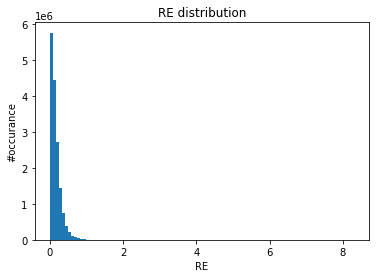

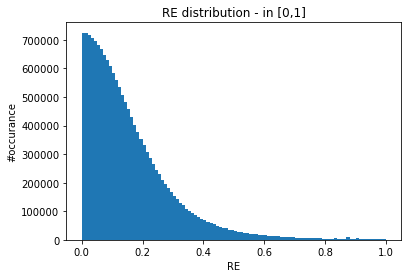

In [11]:
# distribution of relative error in total

relative_errors_total = []
for source in relative_errors.keys():
    relative_errors_total += relative_errors[source]
    #print(source, ': ' ,min(relative_errors[source]))

plt.hist(relative_errors_total, bins = 100)
plt.title('RE distribution')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()

plt.hist([relative_errors_total[i] for i in range(len(relative_errors_total)) if (relative_errors_total[i] < 1.0 and relative_errors_total[i] > 0.0)], bins = 100)
plt.title('RE distribution - in [0,1]')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()

In [ ]:
# Cumulative Distribution Function of the Distribution if Relative Errors

base = [relative_errors_total[i] for i in range(len(relative_errors_total)) if (relative_errors_total[i] < 1.5 and relative_errors_total[i] > 0.0)]
count, bins_count = np.histogram(base, bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF")
plt.title('CDF of Relative Error')
plt.xlabel('Relative Error')
plt.ylabel('CDF')
plt.show()

In [23]:
# Is there any extremely bad node???

bad_nodes = sorted(range(len(ARE_per_source)), key=lambda i: ARE_per_source[i])[-10:]
print('Nodes with the highest REs: ', bad_nodes)
print('Highest REs:', [round(ARE_per_source[bad_node], 3) for bad_node in bad_nodes])



Nodes with the highest REs:  [410, 112, 1099, 822, 993, 943, 1564, 1593, 1870, 573]
Highest REs: [0.322, 0.322, 0.328, 0.337, 0.346, 0.347, 0.348, 0.363, 0.364, 0.368]
